In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob

from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [5]:
# 读取所有 CSV 文件
file_list = glob.glob('../../data/SEO/*.csv')

for i in range(len(file_list)):
    url = file_list[i]
    
    # 提取文件名（去掉路径）
    file_name = Path(file_list[i]).stem  # 获取 '2025.01.22'

    # 替换文件名中的 '.' 为 '-' (防止干扰日期解析)
    formatted_date = file_name.replace('.', '-')

    try:
        # 将格式化后的日期字符串转换为日期对象
        day = pd.to_datetime(formatted_date, format='%Y-%m-%d').day_name()
    except ValueError:
        day = 'Invalid Date'  # 如果解析失败，标记为无效日期

    # 存储到字典格式
    file_list[i] = {day: url}

print(file_list)

[{'Wednesday': '../../data/SEO/2025.01.22.csv'}, {'Thursday': '../../data/SEO/2025.01.23.csv'}, {'Friday': '../../data/SEO/2025.01.24.csv'}, {'Saturday': '../../data/SEO/2025.01.25.csv'}, {'Sunday': '../../data/SEO/2025.01.26.csv'}]


# Workdays

In [6]:
# 按小时顺序排序（手动定义时间段顺序）
hour_order = [
    '12 am – 1 am', '1 am – 2 am', '2 am – 3 am', '3 am – 4 am',
    '4 am – 5 am', '5 am – 6 am', '6 am – 7 am', '7 am – 8 am',
    '8 am – 9 am', '9 am – 10 am', '10 am – 11 am', '11 am – 12 pm',
    '12 pm – 1 pm', '1 pm – 2 pm', '2 pm – 3 pm', '3 pm – 4 pm',
    '4 pm – 5 pm', '5 pm – 6 pm', '6 pm – 7 pm', '7 pm – 8 pm',
    '8 pm – 9 pm', '9 pm – 10 pm', '10 pm – 11 pm', '11 pm – 12 am'
]

Workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

Workdays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Workdays]
Workdays = pd.concat(Workdays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Workdays['Impressions'] = pd.to_numeric(Workdays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Workdays['Avg. CPC'] = Workdays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Workdays['Cost'] = Workdays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Workdays_grouped = Workdays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 显示最终结果
print(Workdays_grouped)

             Hour    Clicks  Impressions  Avg. CPC      Cost
6    12 am – 1 am  0.666667    18.333333  0.646667  0.646667
0     1 am – 2 am  1.000000    21.000000  0.333333  0.580000
8     2 am – 3 am  0.666667     9.333333  0.216667  0.430000
10    3 am – 4 am  0.666667     7.666667  0.500000  0.500000
12    4 am – 5 am  1.000000     4.333333  0.420000  0.600000
14    5 am – 6 am  0.000000     5.333333  0.000000  0.000000
16    6 am – 7 am  0.000000     4.333333  0.000000  0.000000
18    7 am – 8 am  0.333333     4.666667  0.323333  0.323333
20    8 am – 9 am  0.333333     5.333333  0.106667  0.106667
22   9 am – 10 am  0.666667    13.333333  0.223333  0.446667
2   10 am – 11 am  1.333333    13.000000  0.513333  0.843333
4   11 am – 12 pm  1.333333    22.666667  0.350000  0.696667
7    12 pm – 1 pm  5.000000    40.000000  1.226667  5.926667
1     1 pm – 2 pm  3.666667    59.666667  0.943333  3.363333
9     2 pm – 3 pm  3.666667    67.666667  1.030000  3.523333
11    3 pm – 4 pm  1.000

In [7]:
workdays_X = Workdays_grouped.drop(columns=['Hour']).reset_index(drop=True)
workdays_Y = Workdays_grouped['Hour'].reset_index(drop=True)

train_workdays_X, test_workdays_X, train_workdays_Y, test_workdays_Y = train_test_split(
    workdays_X, workdays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_workdays_X = scaler.fit_transform(train_workdays_X)
train_workdays_X

array([[0.13333333, 0.19704433, 0.18206522, 0.07536558],
       [0.73333333, 0.8817734 , 0.76902174, 0.56749156],
       [0.2       , 0.31034483, 0.27173913, 0.09786277],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.07881773, 0.        , 0.        ],
       [0.13333333, 0.13793103, 0.17663043, 0.07255343],
       [1.        , 0.591133  , 1.        , 1.        ],
       [0.2       , 0.13793103, 0.72554348, 0.1799775 ],
       [0.13333333, 0.11330049, 0.4076087 , 0.08436445],
       [0.2       , 0.06403941, 0.3423913 , 0.10123735],
       [0.        , 0.        , 0.        , 0.        ],
       [0.13333333, 0.09852217, 0.25      , 0.10348706],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.06666667, 0.06896552, 0.26358696, 0.05455568],
       [0.26666667, 0.19211823, 0.41847826, 0.14229471],
       [0.73333333, 1.        , 0.83967391, 0.59448819],
       [0.        , 0.        ,

最佳 K 值: 2, 轮廓系数: 0.763


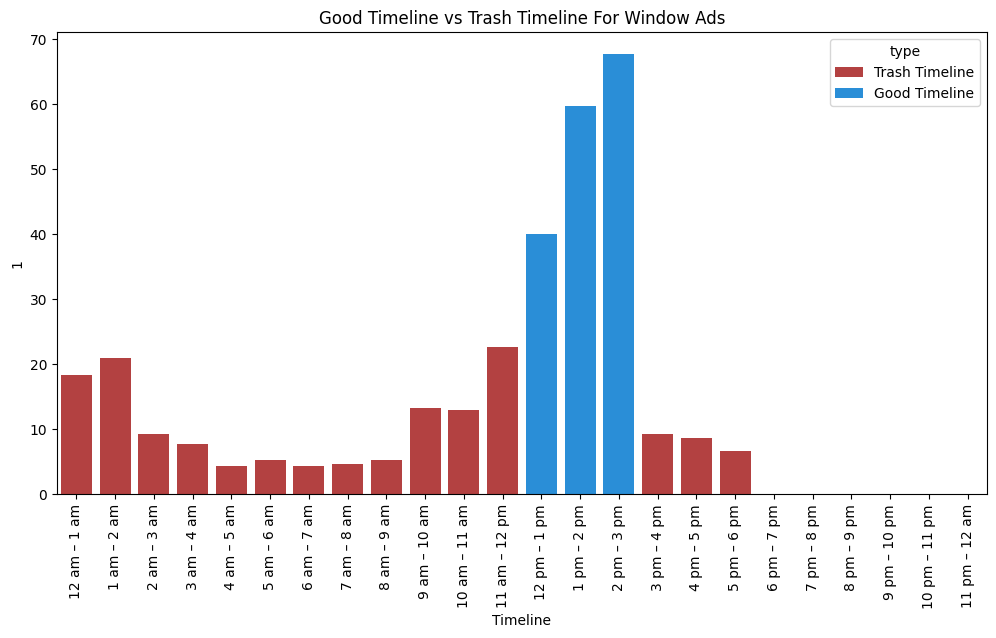

In [8]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_workdays_X)
    score = silhouette_score(train_workdays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Workdays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(workdays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Workdays_grouped['Cluster_Label'] = Workdays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Workdays_grouped['Value'] = Workdays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Trash Timeline': '#C62E2E',
    'Good Timeline': '#0D92F4',
    
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Workdays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()

# Holidays

In [9]:
Holidays = ['Saturday', 'Sunday']

Holidays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Holidays]
Holidays = pd.concat(Holidays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Holidays['Impressions'] = pd.to_numeric(Holidays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Holidays['Avg. CPC'] = Holidays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Holidays['Cost'] = Holidays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Holidays_grouped = Holidays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 显示最终结果
print(Holidays_grouped)

             Hour  Clicks  Impressions  Avg. CPC   Cost
6    12 am – 1 am     2.5         31.5     0.650  1.575
0     1 am – 2 am     1.0         20.0     0.630  0.630
8     2 am – 3 am     2.5         26.0     0.695  1.795
10    3 am – 4 am     1.5          7.0     0.400  0.715
12    4 am – 5 am     0.5          8.5     0.310  0.310
14    5 am – 6 am     0.5          7.0     0.090  0.090
16    6 am – 7 am     0.0          6.0     0.000  0.000
18    7 am – 8 am     1.0         10.0     0.265  0.530
20    8 am – 9 am     1.0          8.0     0.250  0.250
22   9 am – 10 am     0.5         16.5     0.070  0.070
2   10 am – 11 am     1.0         25.0     0.435  0.435
4   11 am – 12 pm     1.5         27.5     0.515  0.770
7    12 pm – 1 pm     3.0         32.5     0.385  1.180
1     1 pm – 2 pm     1.0         31.0     0.205  0.410
9     2 pm – 3 pm     3.5         36.5     0.640  2.095
11    3 pm – 4 pm     3.0         36.0     0.665  2.005
13    4 pm – 5 pm     4.0         30.0     0.555

In [10]:
Holidays_X = Holidays_grouped.drop(columns=['Hour']).reset_index(drop=True)
Holidays_Y = Holidays_grouped['Hour'].reset_index(drop=True)

train_holidays_X, test_holidays_X, train_holidays_Y, test_holidays_Y = train_test_split(
    Holidays_X, Holidays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_holidays_X = scaler.fit_transform(train_holidays_X)
train_holidays_X

array([[0.14285714, 0.28695652, 0.10071942, 0.03341289],
       [0.28571429, 0.53913043, 0.29496403, 0.19570406],
       [0.28571429, 0.34782609, 0.90647482, 0.30071599],
       [0.57142857, 0.60869565, 0.55395683, 0.7326969 ],
       [0.14285714, 0.12173913, 0.1294964 , 0.04295943],
       [0.71428571, 0.45217391, 1.        , 0.85680191],
       [0.85714286, 0.56521739, 0.55395683, 0.56324582],
       [0.85714286, 0.62608696, 0.95683453, 0.95704057],
       [0.42857143, 0.12173913, 0.57553957, 0.34128878],
       [0.14285714, 0.14782609, 0.44604317, 0.14797136],
       [0.14285714, 0.02608696, 0.54676259, 0.18138425],
       [0.28571429, 0.53043478, 0.62589928, 0.20763723],
       [0.85714286, 1.        , 0.76258993, 0.69212411],
       [0.        , 0.        , 0.        , 0.        ],
       [0.28571429, 0.17391304, 0.38129496, 0.25298329],
       [0.28571429, 0.43478261, 0.62589928, 0.20763723],
       [1.        , 0.63478261, 0.92086331, 1.        ],
       [1.        , 0.80869565,

最佳 K 值: 2, 轮廓系数: 0.558


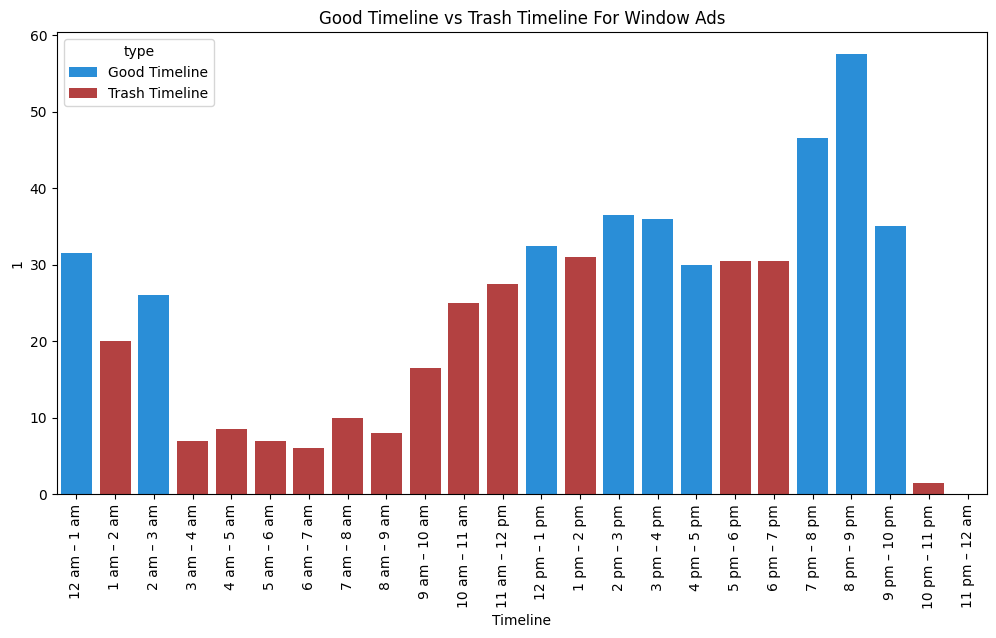

In [11]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_holidays_X)
    score = silhouette_score(train_holidays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Holidays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(Holidays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Holidays_grouped['Cluster_Label'] = Holidays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Holidays_grouped['Value'] = Holidays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Good Timeline': '#0D92F4',
    'Trash Timeline': '#C62E2E'
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Holidays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()